## 주식예측 모델
### Stock_Prediction
***
#### STEP 1 : 시계열 데이터 준비
-칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  
-날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만,  
우리는 Close만 사용하겠습니다.  
(주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)  

#### STEP 2 : 각종 전처리 수행
-결측치 처리  
-로그 변환  

#### STEP 3 : 시계열 안정성 분석
-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인  

#### STEP 4 : 학습, 테스트 데이터셋 생성
-학습, 테스트 데이터셋 분리  

#### STEP 5 : 적정 ARIMA 모수 찾기
-ACF, PACF 그려보기 -> p,q 구하기  
-차분 안정성 확인 -> d 구하기  

#### STEP 6 : ARIMA 모델 훈련과 테스트
-ARIMA 모델 빌드와 훈련  
-모델 테스트 및 플로팅  
-최종 예측 모델 정확도 측정(MAPE)   

#### STEP 7 : 다른 주식 종목 예측해 보기
-관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기 
***
#### 평가문항
**1. 시계열의 안정성이 충분히 확인되었는가?**  
-플로팅과 adfuller 메소드가 모두 적절히 사용되었음 

**2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?**  
-p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

**3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?**  
-3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨
***
#### STEP 1 : 시계열 데이터 준비
-칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  
-날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만,  
우리는 Close만 사용하겠습니다.  
(주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)  
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

삼성전자의 주식 데이터를 다운받은 후, 날짜에 따른 종가만 가져온 것을 확인하였습니다.  
이제 이 시리즈데이터를 가지고 여러가지 전처리를 수행하겠습니다.  
***
#### STEP 2 : 각종 전처리 수행
-결측치 처리  
-로그 변환  
***

In [2]:
ts[ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

결측치가 있는지 우선 확인해 보았습니다.  
확인결과 6개의 결측치가 있는것으로 확인되었습니다.
결측치를 확인하는 메소드는 판다스의 .isna()입니다.  
또한 결측치를 보간하는 메소드는 판다스의 .interpolate(method='time')입니다.  
이 메소드는 index에 존재하는 'time'열을 이준으로 보간합니다.  
[.interpolate()](https://rfriend.tistory.com/264)  
해당 메소드를 활용하여 결측치를 보간하고 다시 확인해보겠습니다.

In [3]:
ts=ts.interpolate(method='time')

In [4]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 보간된 것을 확인하였으니, 해당 데이터의 안정성을 확인해 보겠습니다.  
우선 그래프로 먼저 확인해보겠습니다.  

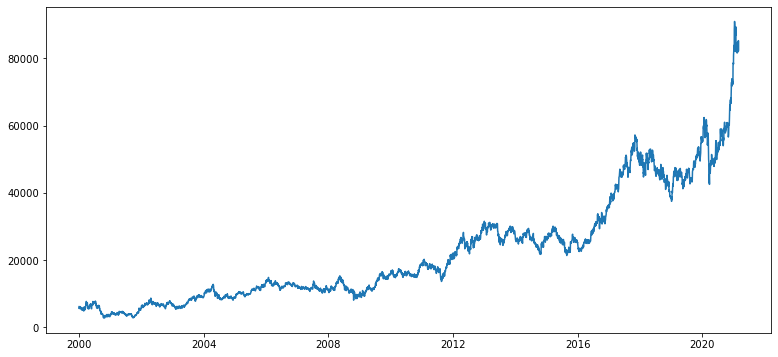

In [5]:
plt.plot(ts)

2020-03 직후 점차 안정정으로 오르는 듯 보이다가 2020-11이후 급격한 변화를 보입니다.  
시간 추이에 따라 점점 증가하고있음은 명확해보이니 로그함수 변환을 통해  
변화폭을 줄여 안정성을 줄 수 있을 것 같습니다.  
우선 ADF Test(Augmented Dickey-Fuller Test)를 통해 얼마나 안정성이 떨어지는지  
확인해보도록 하겠습니다.

In [6]:
# ADF Test를 위한 라이브러리 import
from statsmodels.tsa.stattools import adfuller

# 차후에도 ADF Test를 시행하기 위한 ADF 함수 생성
def augmented_dickey_fuller_test(timeseries):
    # adfuller 메소드 호출
    dftest=adfuller(timeseries, autolag='AIC')
    
    # adfuller가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Crritical Value (%s)' % key]=value
    print(dfoutput)

In [7]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test
Test Statistic                    2.000055
p-value                           0.998673
#Lags Used                       28.000000
Number of Observations Used    5289.000000
Crritical Value (1%)             -3.431587
Crritical Value (5%)             -2.862087
Crritical Value (10%)            -2.567061
dtype: float64


안정성의 척도인 p-value가 1에 가깝게 나왔습니다.  
0에 가까울수록 안정적이라는 뜻이니 전혀 안정적이지 않다는것을 알 수 있습니다.  
그렇다면 로그변환을 적용했을때는 얼마나 변하게 될까요?  

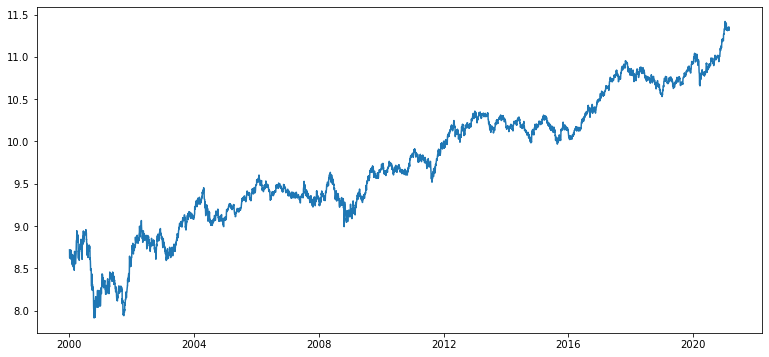

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

그래프상으로 살펴보았을때는 그래프의 추이가 크게 변하지는 않았습니다.  
그러나 주식값을 확인해보면 값의 크기가 작아진 것을 확인할 수 있습니다.  
그렇다면 로그변환한 시리즈데이터를 가치고 ADF Test를 시행하겠습니다.  

In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test
Test Statistic                   -0.325391
p-value                           0.921830
#Lags Used                        4.000000
Number of Observations Used    5313.000000
Crritical Value (1%)             -3.431581
Crritical Value (5%)             -2.862084
Crritical Value (10%)            -2.567060
dtype: float64


큰 폭으로 줄지는 않았지만 그래도 조금이라도 준 것을 확인할 수 있습니다.  
***
#### STEP 3 : 시계열 안정성 분석
-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인  
***
우리는 위의 전처리과정을 통해 결측치를 처리해보았고,  
로그함수 변환을 통해 주식값의 크기를 작게하여 변동성의 크기를 줄였습니다.  
이번에는 처리를 마친 시리즈데이터를 우선 시각화해서 뜯어보겠습니다.  

In [10]:
# 일정 기간을 설정하고 그 기간에 따른 구간평균과 표준편차를 구하는 함수 생성
def plot_rolling_statistics(timeseries, window=12):
    # 이동평균 시계열
    rolmean = timeseries.rolling(window = window).mean()
    
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window = window).std()
    
    
    # 원본 시계열, 이동평균, 이동표준편차를 그래프에 시각화하기
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(timeseries, color = 'red', label='Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rrolling Mean & Standard Deviation')
    plt.show(block=False)

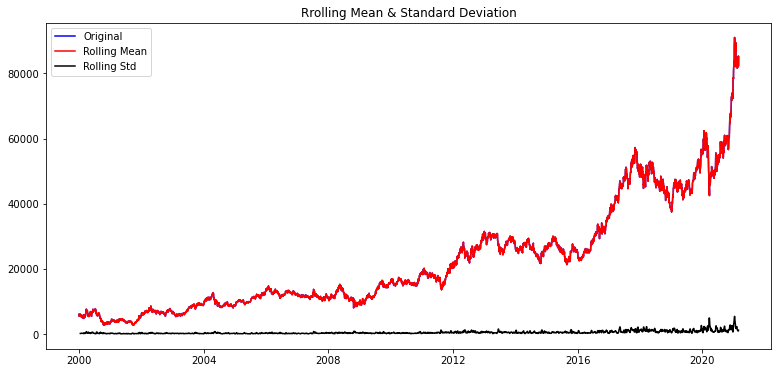

In [11]:
# 원본 데이터로 확인
plot_rolling_statistics(ts, window=12)

우선 원본 데이터를 가지고 확인해 보았습니다.  
이동평균과 분산 보두 증가하는 추세를 보이고있습니다.  
이러한 이유로 인해 위의 Step에서 시행했던 ADF Test에서  
p-value의 값이 1에 가깝게 나왔던 것 같습니다.  
그렇다면 로그변환을 시행한 데이터는 어떨까요?

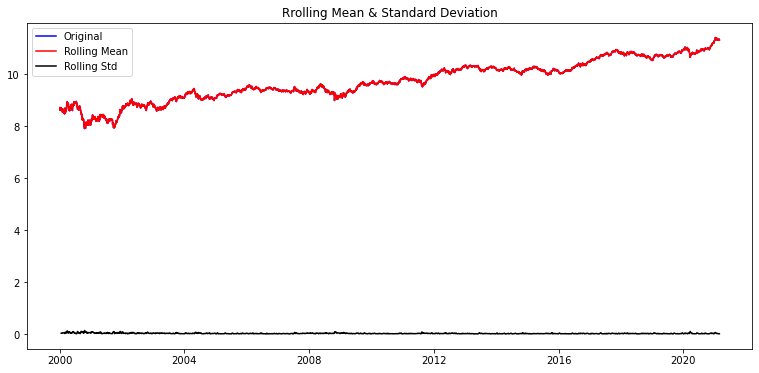

In [12]:
# 로그변환을 시행한 데이터로 확인
plot_rolling_statistics(ts_log, window=12)

로그변환을 시행한 데이터로 확인하였음에도 불구하고,  
이동평균이 점차 증가하는 것을 확인할 수 있었습니다.  
다만, 분산의 경우 원본데이터보다는 변화가 미미해 진것을 확인하였습니다.  
p-value가 줄어든 것은 이때문이었던 것 같습니다.  
우리는 지금 주식값의 변동을 예측하여야하므로 데이터를 좀더 안정적으로 만들 필요가 있습니다.  
따라서 값이 점점 증가하는 추세(Trend)나, 계절성제거(1st order differencing)을 통해   
해당 시리즈 데이터를 좀 더 안정적으로 만들어 보겠습니다.  

In [13]:
ts_sort=ts_log.sort_index(inplace= True)

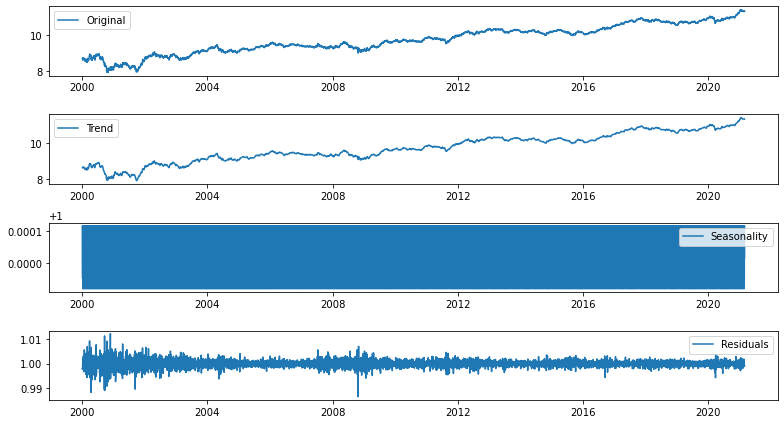

In [14]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test
Test Statistic                  -21.604541
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5280.000000
Crritical Value (1%)             -3.431589
Crritical Value (5%)             -2.862088
Crritical Value (10%)            -2.567061
dtype: float64


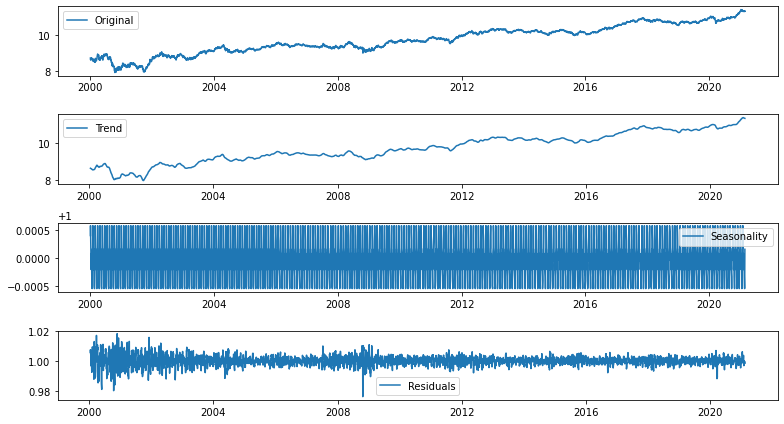

In [16]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=20)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test
Test Statistic                -1.849333e+01
p-value                        2.125349e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.264000e+03
Crritical Value (1%)          -3.431593e+00
Crritical Value (5%)          -2.862089e+00
Crritical Value (10%)         -2.567062e+00
dtype: float64


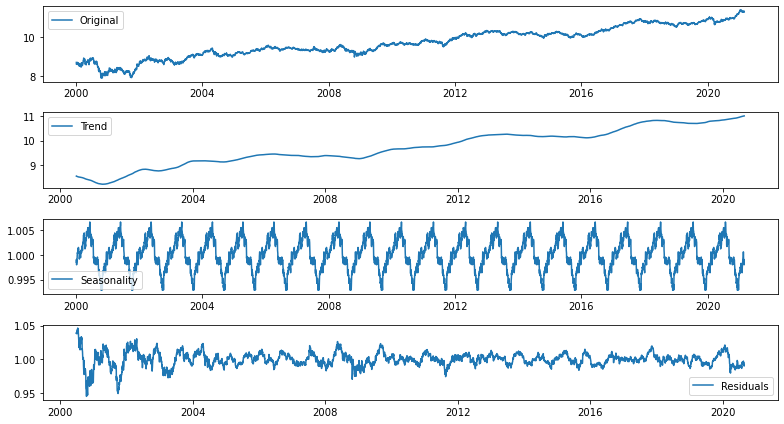

In [18]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=253)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test
Test Statistic                -9.029404e+00
p-value                        5.496890e-15
#Lags Used                     3.100000e+01
Number of Observations Used    5.034000e+03
Crritical Value (1%)          -3.431650e+00
Crritical Value (5%)          -2.862114e+00
Crritical Value (10%)         -2.567076e+00
dtype: float64


statsmodels 라이브러리 안에 있는 seasonal_decompose메소드를 사용하여,  
시계열 분해를 진행하였습니다.  
주식의 데이터는 한주에 5일 한달에 20일 1년에 253일 거래를 진행하므로,  
주기를 5일, 20일, 253일로 나누어 ts_log를 기준으로 Rresidul(잔차)의  
시계열 분해와 ADF Test를 진행하여 p-value를 확인하였습니다.  
확인 결과 20일주기가 가장 낮은 p-value를 가지는 것으로 확인되었습니다.  
***
#### STEP 4 : 학습, 테스트 데이터셋 생성
-학습, 테스트 데이터셋 분리  
***

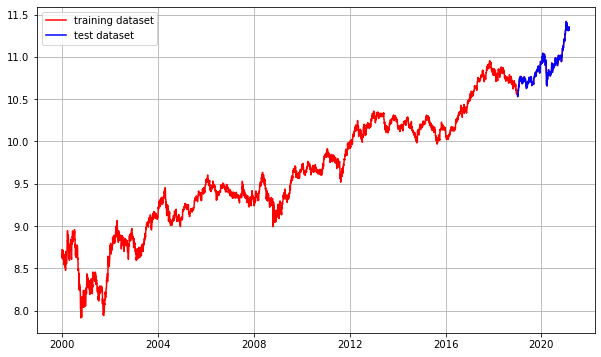

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)],ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

훈련데이터와 데스트데이터가 잘 분리된 것을 확인하였습니다.  
그럼 이제 ARIMA모델에 적용할 p,q,d를 구해보겠습니다.
***
#### STEP 5 : 적정 ARIMA 모수 찾기
-ACF, PACF 그려보기 -> p,q 구하기  
-차분 안정성 확인 -> d 구하기  
***

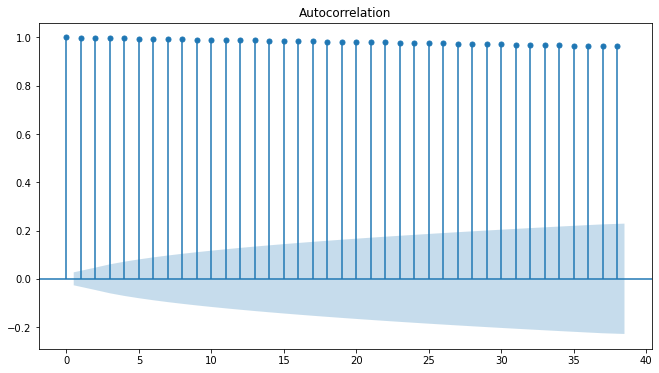

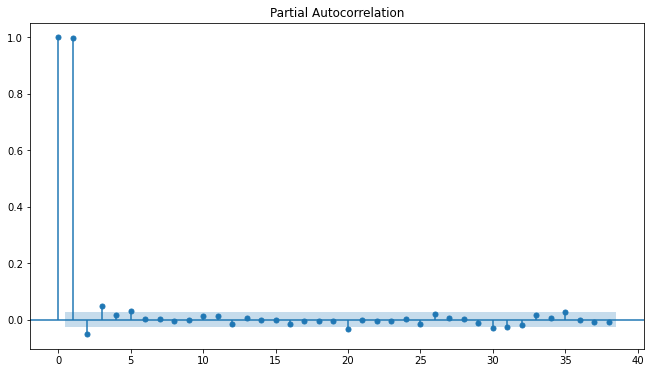

Results of Dickey-Fuller Test
Test Statistic                  -40.102097
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5313.000000
Crritical Value (1%)             -3.431581
Crritical Value (5%)             -2.862084
Crritical Value (10%)            -2.567060
dtype: float64


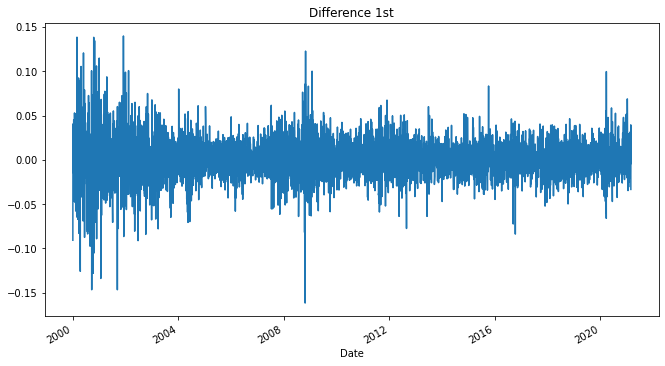

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test
Test Statistic                  -40.102097
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5313.000000
Crritical Value (1%)             -3.431581
Crritical Value (5%)             -2.862084
Crritical Value (10%)            -2.567060
dtype: float64


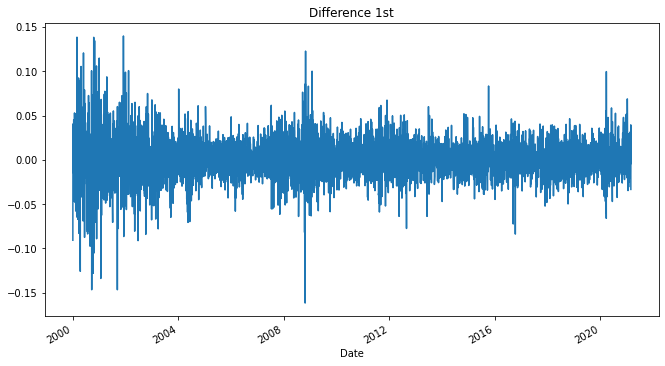

In [22]:
# 2차 차분 구하기
diff_2 = ts_log.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_2)

ACF그래프를 확인해보았을때는 점차 감소하는 추세를 보이고 있으나,  
적합한 q값을 찾을수는 없었습니다.  
이 q값은 모델을 돌려보면서 조정하도록 하겠습니다.  
PACF그래프에서는 p=1이 적절할 것으로 판단됩니다.  
차분 안정성을 그래프를 통해 확인해 본 결과  
d값 역시 1이 적당해 보입니다.  
[p=1, d=1, q=0]  
그럼 이제 ARIMA모델을 만들어 학습을 진행해 보겠습니다.  
***
#### STEP 6 : ARIMA 모델 훈련과 테스트
-ARIMA 모델 빌드와 훈련  
-모델 테스트 및 플로팅  
-최종 예측 모델 정확도 측정(MAPE)   
***

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA모델 만들기 (order = p=1, d=1, q=0)
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4785
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11277.411
Method:                       css-mle   S.D. of innovations              0.023
Date:                Mon, 01 Mar 2021   AIC                         -22548.823
Time:                        17:31:57   BIC                         -22529.403
Sample:                             1   HQIC                        -22542.001
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.111      0.266      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

모델생성은 마무리 되었습니다.  
이제 모델이 잘 학습하였는지 시각적으로 확인해보겠습니다.  

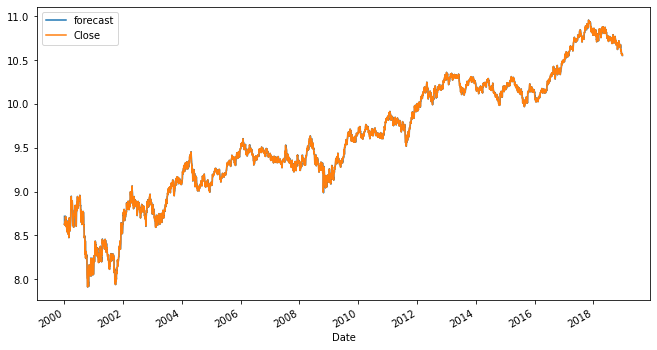

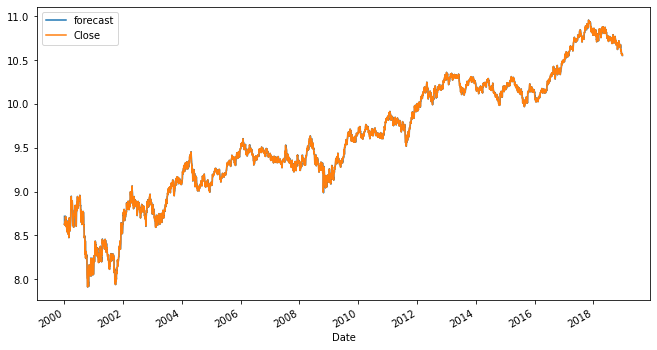

In [24]:
fitted_m.plot_predict()

그래프로 보아서는 잘 학습이 된것 같습니다.  
이제 forecast()메소드를 이용해 데이터를 예측해 보겠습니다.  

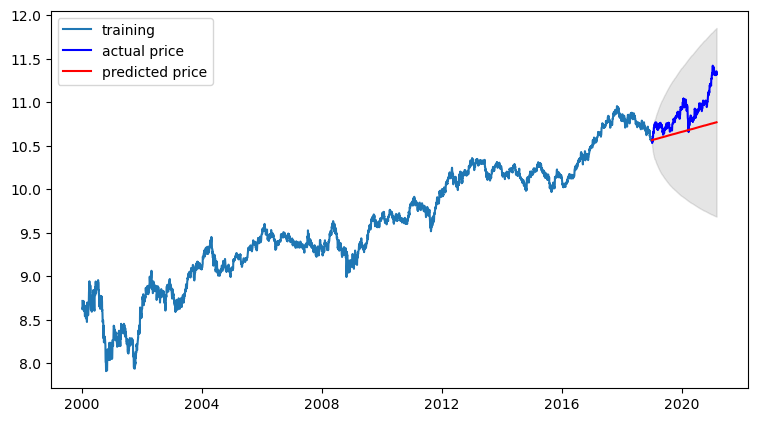

In [25]:
#forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data),alpha=0.05) # 95% conf

#예측 결과와 상한 하한을 시리즈데이터로 만듭니다.
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

시각화는 완료가 되었으니 이제 오차를 수치화해서 정확도를 확인해 보겠습니다.

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  214746746.26469508
MAE:  11296.362313772373
RMSE:  14654.239873316359
MAPE: 18.68%


MAPE기준 18.68의 오차율을 가지게 되었습니다.  
다른 종목은 어떨지 한번 확인해보겠습니다.  
***
#### STEP 7 : 다른 주식 종목 예측해 보기
-관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기 
***
**-google**

In [32]:
google_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
gg_df = pd.read_csv(google_filepath, index_col='Date', parse_dates=True)
gg_ts = gg_df['Close']

In [33]:
gg_ts=gg_ts.interpolate(method='time')
gg_ts[gg_ts.isna()]

Series([], Name: Close, dtype: float64)

Results of Dickey-Fuller Test
Test Statistic                    2.584336
p-value                           0.999072
#Lags Used                       30.000000
Number of Observations Used    4129.000000
Crritical Value (1%)             -3.431935
Crritical Value (5%)             -2.862240
Crritical Value (10%)            -2.567143
dtype: float64


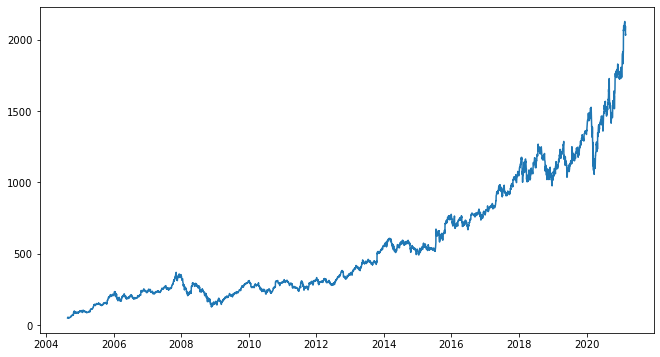

In [34]:
augmented_dickey_fuller_test(gg_ts)
plt.plot(gg_ts)

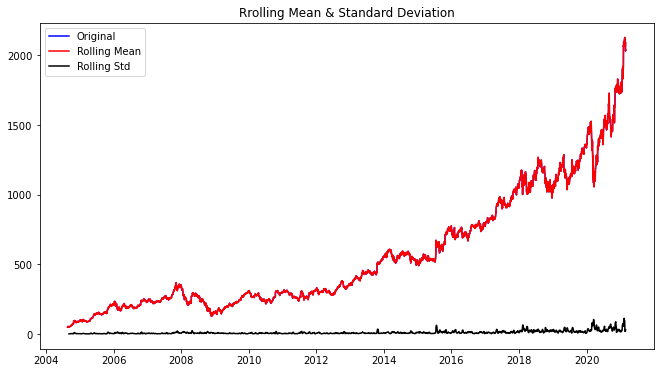

In [35]:
plot_rolling_statistics(gg_ts, window=12)

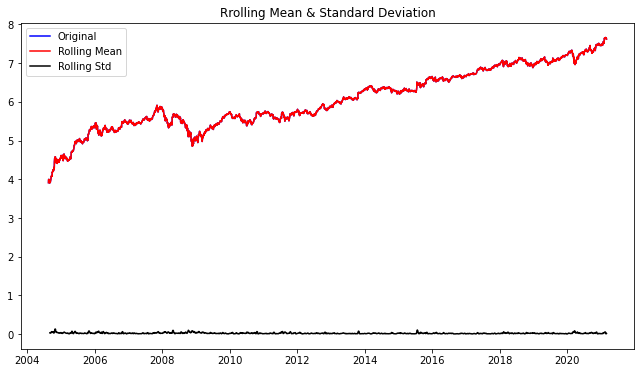

In [37]:
gg_log = np.log(gg_ts)
plot_rolling_statistics(gg_log, window=12)

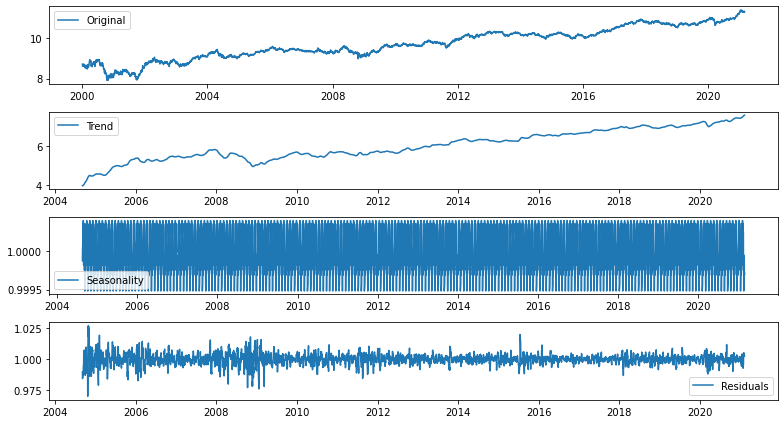

In [40]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(gg_log,model='multiplicative',period=20)

gg_trend = decomposition.trend
gg_seasonal = decomposition.seasonal
gg_residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [41]:
gg_residual.dropna(inplace=True)
augmented_dickey_fuller_test(gg_residual)

Results of Dickey-Fuller Test
Test Statistic                -1.622185e+01
p-value                        3.890567e-29
#Lags Used                     3.000000e+01
Number of Observations Used    4.109000e+03
Crritical Value (1%)          -3.431942e+00
Crritical Value (5%)          -2.862244e+00
Crritical Value (10%)         -2.567145e+00
dtype: float64


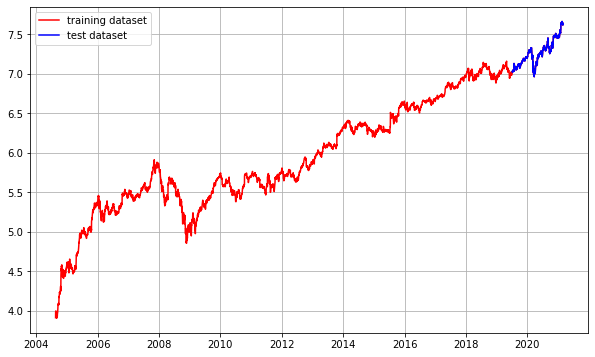

In [43]:
gg_train_data, gg_test_data = gg_log[:int(len(gg_log)*0.9)],gg_log[int(len(gg_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(gg_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(gg_test_data, c='b', label='test dataset')
plt.legend()

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3743
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9545.629
Method:                       css-mle   S.D. of innovations              0.019
Date:                Mon, 01 Mar 2021   AIC                         -19085.257
Time:                        17:40:59   BIC                         -19066.574
Sample:                             1   HQIC                        -19078.612
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.664      0.008       0.000       0.001
ar.L1.D.Close     0.0108      0.016      0.657      0.511      -0.021       0.043
                                    Root

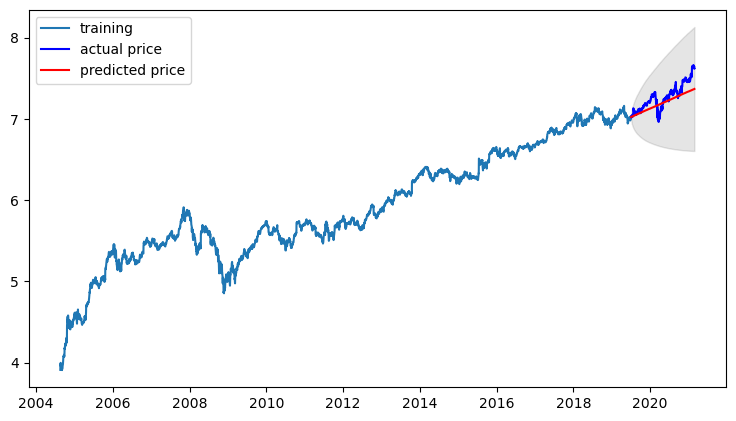

MSE:  31001.109386522035
MAE:  132.82920717001605
RMSE:  176.07131903442433
MAPE: 8.47%


In [44]:
model = ARIMA(gg_train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

#forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(gg_test_data),alpha=0.05) # 95% conf

#예측 결과와 상한 하한을 시리즈데이터로 만듭니다.
fc_series = pd.Series(fc, index=gg_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=gg_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=gg_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(gg_train_data, label='training')
plt.plot(gg_test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(gg_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(gg_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(gg_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(gg_test_data))/np.abs(np.exp(gg_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
